# Linear Modeling in `edges-analysis`

In this tutorial, we'll cover how to use the linear modeling tools in `edges-analysis` to fit and analyze data. Linear models are used within `edges-analysis` for a variety of tasks, including calibration of reflection coefficients, noise modeling for RFI extraction, and signal
fitting. 

Since the `edges.modeling` module is, well, modular, you can also use it externally
for your own linear modeling needs!

## Importing

In [1]:
# The main linear modeling module
from edges import modeling as mdl

# Some other imports to help us out in this tutorial
import numpy as np
import matplotlib.pyplot as plt

## Setting up a linear model

Linear models are set up using sub-classes of the `Model` base class found in the `edges.modeling` module. These sub-classes define specific types of linear models, such as polynomials, sinusoids, or custom basis functions. For example, to create a linear model with basis
terms composed of Fourier series, you can use the `Fourier` class:

In [2]:
poly = mdl.Polynomial(n_terms=4)

We have specified this model *instance* to have 4 terms (i.e. a polynomial of degree 3). 
Most models have a flexible number of terms (e.g. polynomials can have any degree), so you can
specify the number of terms when you create the model instance.

Some models however have fixed numbers of terms, or an acceptable range of number
of terms. for example the `PhysicalIono` model has 
up to 5 terms, and trying to specify more will raise an error:

In [3]:
try:
    physical_iono = mdl.models.PhysicalIono(n_terms=10)
except ValueError as e:
    print(f"Error creating PhysicalIono model: {e}")

Error creating PhysicalIono model: n_terms must be between 1 and 5


A model instance is meant to be quite abstract -- for example, you do not specify
which coordinates it should be evaluated at. While you can specify the coordinates 
directly when fitting the model, it is often useful to specify them beforehand so that
the basis functions are pre-computed. You can do this with the `.at()` method:

In [4]:
polyx = poly.at(x=np.linspace(0,1, 100))

This is now a an instance of the `FixedLinearModel` class, which is *fixed* to a set
of particular coordinates.

In [5]:
type(polyx)

edges.modeling.core.FixedLinearModel

A Fixed linear model has well-defined basis functions at the specified coordinates, which
can be accessed via the `.basis` attribute:

In [6]:
polyx.basis.shape

(4, 100)

To gain access to the underlying abstract model, simply use the `.model` attribute:

In [7]:
polyx.model

Polynomial(parameters=None, n_terms=4, _transform=IdentityTransform(), xtransform=IdentityTransform(), basis_scaler=None, data_transform=IdentityTransform(), offset=0.0, spacing=1.0)

Both a `Model` and `FixedLinearModel` instance can be *evaluated* at a set of coordinates
and a set of coefficients using the `__call__` method. For example, to evaluate the
Fourier model at the specified coordinates with random coefficients:

In [8]:
rng = np.random.default_rng(42)

coeffs = rng.normal(size=poly.n_terms)

evaluated = poly(x=np.linspace(0,1,100), parameters=coeffs)

or equivalently:

In [9]:
evaluated_fixed = polyx(parameters=coeffs) # no need to specify x

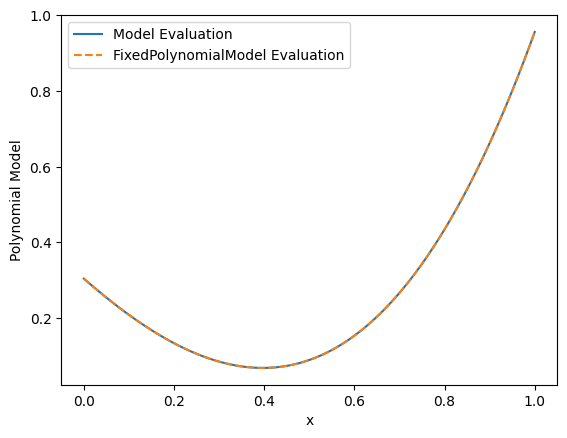

In [10]:
plt.plot(polyx.x, evaluated)
plt.plot(polyx.x, evaluated_fixed, '--')
plt.xlabel("x")
plt.ylabel("Polynomial Model")
plt.legend(["Model Evaluation", "FixedPolynomialModel Evaluation"])

## Fitting a linear model to data

To fit a linear model to data, you can use the `.fit()` method of the `FixedLinearModel` (or `Model`) instance. This method takes in the data to be fitted and returns the best-fit coefficients for the model. For example, let's create some synthetic data using the evaluated model and add some noise:

In [11]:
data = evaluated + 0.01 * rng.normal(size=evaluated.shape)

To fit our *fixed* linear model to this data:

In [12]:
modelfit = polyx.fit(ydata=data)

Conversely, we could have fit the original `Model` instance by specifying the coordinates directly:

In [13]:
modelfit_nonfixed = poly.fit(xdata=polyx.x, ydata=data)

The object returned by the `.fit()` method contains the best-fit coefficients, which can be accessed via the `model_parameters` attribute:

In [14]:
print("Fit coefficients: ", np.array(modelfit.model_parameters))
print("True coefficients:", coeffs)

Fit coefficients:  [ 0.2998308  -0.98691767  0.63236707  1.00964765]
True coefficients: [ 0.30471708 -1.03998411  0.7504512   0.94056472]


The `ModelFit` object can be used to evaluate the fitted model at any set of coordinates using 
the `.evaluate()` method (default is to use the original coordinates used in the fit).
Furthermore, residuals of the fit can be obtained using the `.residual` attribute:

Text(0, 0.5, 'Residual')

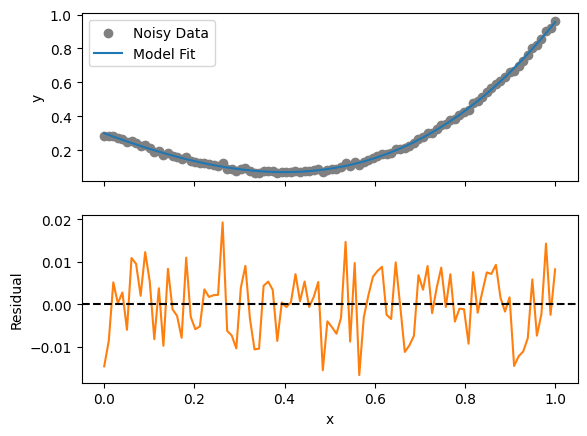

In [16]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].scatter(polyx.x, data, label="Noisy Data", color='gray')
ax[0].plot(polyx.x, modelfit.evaluate(), label="Model Fit", color='C0')

ax[1].plot(polyx.x, modelfit.residual, label="Residual", color='C1')
ax[1].axhline(0, color='black', linestyle='--')
ax[0].legend()

ax[1].set_xlabel("x")
ax[0].set_ylabel("y")
ax[1].set_ylabel("Residual")


### Using weights in the fit

Sometimes the variance in each data point is different, and you may want to weight the fit accordingly. This can be done by providing a weights array to the `.fit()` method. The weights should be inversely proportional to the variance of the data points. For example, let's create a weights array and use it in the fit:

In [18]:
stdev = 0.05 * (0.5 + polyx.x)
weights = 1 / stdev**2

weighted_data = evaluated + rng.normal(scale=stdev)

In [19]:
weighted_fit = polyx.fit(ydata=weighted_data, weights=weights)

Text(0, 0.5, 'Residual')

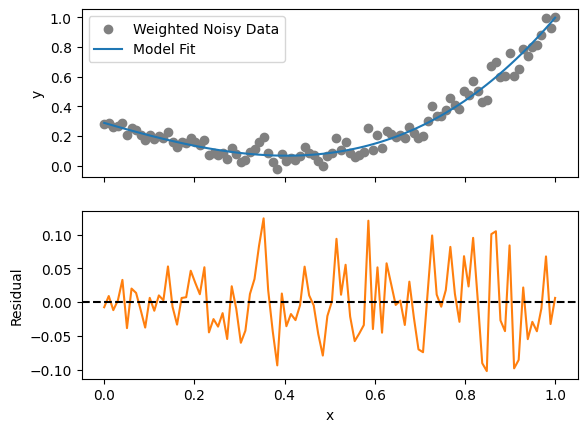

In [21]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].scatter(polyx.x, weighted_data, label="Weighted Noisy Data", color='gray')
ax[0].plot(polyx.x, weighted_fit.evaluate(), label="Model Fit", color='C0')

ax[1].plot(polyx.x, weighted_fit.residual, label="Residual", color='C1')
ax[1].axhline(0, color='black', linestyle='--')
ax[0].legend()

ax[1].set_xlabel("x")
ax[0].set_ylabel("y")
ax[1].set_ylabel("Residual")

In fact, data may have a non-diagonal covariance structure. In this case, you can provide the full covariance matrix to the `.fit()` method using the same `weights` parameter 
(now as a 2D array). The fitting procedure will then take into account the correlations between data points when determining the best-fit coefficients.

### Properties of the Fit

Several basic properties of the fitted model are made available to evaluate the quality of the fit. These include:

In [22]:
# The weighted chi^2 value
print("Weighted Chi^2: ", weighted_fit.weighted_chi2)

# The *reduced* weighted chi^2 value (i.e., chi^2 per degree of freedom)
print("Reduced Weighted Chi^2: ", weighted_fit.reduced_weighted_chi2)

# The weighted RMS of the residuals
print("Weighted RMS of Residuals: ", weighted_fit.weighted_rms)

# The parameter covariance matrix
print("\nParameter Covariance Matrix:\n", weighted_fit.parameter_covariance)

# The parameter correlation matrix
print("\nParameter Correlation Matrix:\n", weighted_fit.parameter_correlation)

Weighted Chi^2:  92.32770615845081
Reduced Weighted Chi^2:  0.9718705911415875
Weighted RMS of Residuals:  0.00017895327414410223

Parameter Covariance Matrix:
 [[ 0.00012597 -0.0011339   0.00253597 -0.00159337]
 [-0.0011339   0.01517344 -0.03908428  0.02639764]
 [ 0.00253597 -0.03908428  0.10945216 -0.0777631 ]
 [-0.00159337  0.02639764 -0.0777631   0.05720814]]

Parameter Correlation Matrix:
 [[ 1.         -0.82015119  0.68295878 -0.59354128]
 [-0.82015119  1.         -0.95906487  0.89597149]
 [ 0.68295878 -0.95906487  1.         -0.98272605]
 [-0.59354128  0.89597149 -0.98272605  1.        ]]


You can also quickly draw sample parameter vectors from the posterior distribution using the `.get_sample()` method:

In [29]:
samples = modelfit.get_sample(size=1000)

Text(0, 0.5, 'Parameter 1')

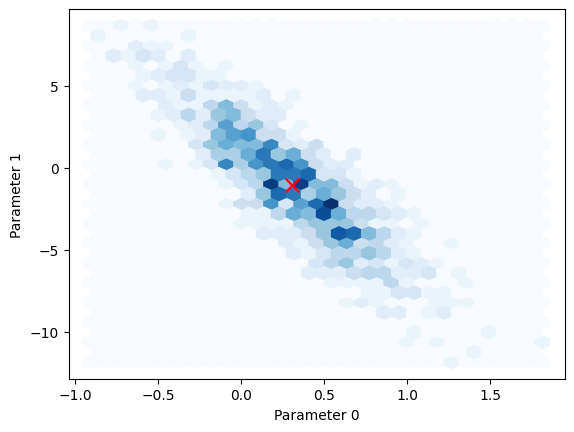

In [30]:
plt.hexbin(samples[:,0], samples[:,1], gridsize=30, cmap='Blues')
plt.scatter(
    [coeffs[0]], 
    [coeffs[1]], 
    color='red', label='Truth', marker='x', s=100
)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")

Finally, if you need to access the `FixedLinearModel` instance that was used in the fit,
but with its parameters set to those of the fit, you can use the `.fit` attribute:

In [34]:
print(type(modelfit.fit))
print(np.array(modelfit.fit.parameters))

<class 'edges.modeling.core.FixedLinearModel'>
[ 0.2998308  -0.98691767  0.63236707  1.00964765]


## Composite Linear Models

Sometimes you may want to fit data using a combination of linear models. This can be achieved using the `CompositeModel` class, which allows you to combine multiple linear models into a single model. Each sub-model can have its own set of basis functions and parameters.

In [37]:
composite = mdl.CompositeModel(
    models = {
        'poly': mdl.Polynomial(n_terms=3),
        'fourier': mdl.Fourier(n_terms=2, period=1.0)
    }
)

Let's create some data that is a combination of a polynomial and a Fourier series:

In [38]:
x = np.linspace(0, 2.3, 100)

true_params = rng.normal(size=composite.n_terms)  # 3 + 2 == 5

cdata = composite(x=x, parameters=true_params) + 0.05 * rng.normal(size=x.shape)

In most ways, a `CompositeModel` looks and behaves like a regular `Model` instance. You can create a fixed version of it, fit it to data, and access its properties in the same way as before:

In [39]:
cmodelfit = composite.at(x=x).fit(ydata=cdata)

Text(0, 0.5, 'Residual')

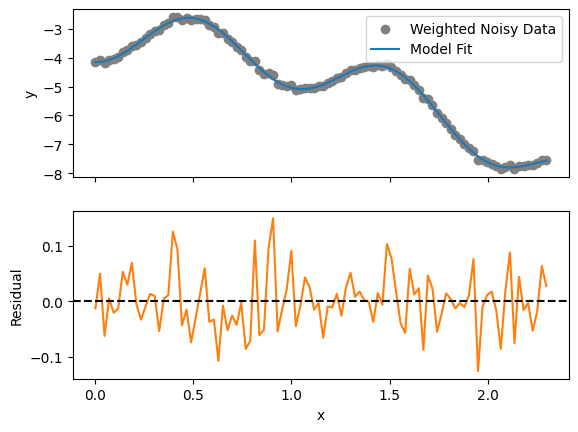

In [40]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].scatter(x, cdata, label="Weighted Noisy Data", color='gray')
ax[0].plot(x, cmodelfit.evaluate(), label="Model Fit", color='C0')

ax[1].plot(x, cmodelfit.residual, label="Residual", color='C1')
ax[1].axhline(0, color='black', linestyle='--')
ax[0].legend()

ax[1].set_xlabel("x")
ax[0].set_ylabel("y")
ax[1].set_ylabel("Residual")

However, here you can also split the model back into its constituent sub-models. For example, to access the polynomial and Fourier sub-models separately, use the `.get_model()` method,
and supply the `model_parameters` of the fit (note that you need to use a `CompositeModel` 
to access `.get_model`, rather than a `FixedLinearModel`):

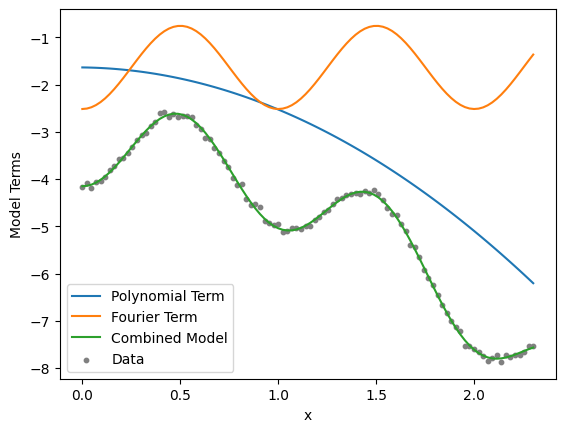

In [ ]:
polyterm = cmodel.get_model("poly", x=x, parameters=cmodelfit.model_parameters)
fourierterm = cmodel.get_model("fourier", x=x, parameters=cmodelfit.model_parameters)

plt.plot(x, polyterm, label="Polynomial Term")
plt.plot(x, fourierterm, label="Fourier Term")
plt.plot(x, polyterm + fourierterm, label="Combined Model")
plt.scatter(x, cdata, label="Data", color='gray', s=10)
plt.xlabel("x")
plt.ylabel("Model Terms")
plt.legend()

## Changing Fitting Methods

The default method used for solving the linear models is `numpy.linalg.lstsq`, which uses a least-squares approach. However, you can change the fitting method using the `method` parameter of the `.fit()` method. Available methods include "qr" and "alan-qrd" (the latter is a QR decomposition method that attempts to replicate a legacy EDGES C-based pipeline, and 
should not usually be used).

In [46]:
qr_fit = composite.at(x=x).fit(ydata=cdata, method='qr')

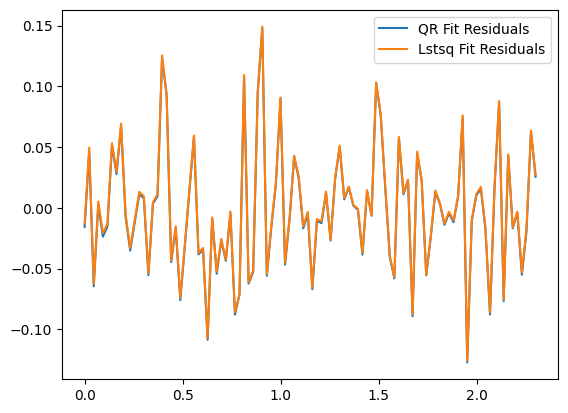

In [48]:
plt.plot(x, qr_fit.residual, label="QR Fit Residuals", color='C0')
plt.plot(x, cmodelfit.residual, label="Lstsq Fit Residuals", color='C1')
plt.legend()

## Data Transformations

The `edges.modeling` package also supports pre-applying transformations to the 
data and coordinates before fitting. When doing so, the same transformations are applied
when evaluating the model, so you can pass in the original (untransformed) coordinates to
get the correct model values.

To create a transform, use a `DataTransform` instance. For example, to create a transform
that normalizes the data into the range (-1,1):

In [55]:
x = np.linspace(50, 100, 125)  # maybe these are frequencies in MHz

transform = mdl.ZerotooneTransform(range=(50, 100))

fourier = mdl.Fourier(n_terms=8, transform=transform, period=1.0)

In [ ]:
p = rng.normal(size=fourier.n_terms)

# Notice that when evaluating the fourier model, we use the original (untransformed) x values
data = fourier(x=x, parameters=p) + 0.1 * rng.normal(size=x.shape)

In [59]:
# Also when fitting, using the untransformed x values

modelfit = fourier.fit(xdata=x, ydata=data)

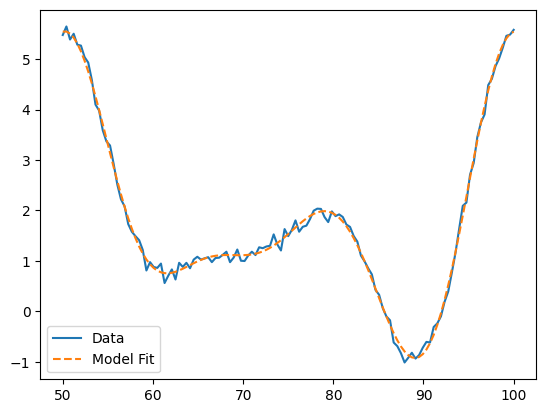

In [61]:
plt.plot(x, data, label='Data')
plt.plot(x, modelfit.evaluate(), label='Model Fit', linestyle='--')
plt.legend()

## Special Composite Models: Complex Functions

There are two special cases of the `CompositeModel` class that are useful for
modeling complex-valued data: `ComplexMagPhaseModel` and `ComplexRealImagModel`. These
models allow you to fit complex data by separating it into magnitude and phase components,
or real and imaginary components, respectively. This is particularly useful in applications such as
modeling reflection coefficients or complex impedance data.

In [64]:
complex_model = mdl.ComplexRealImagModel(
    real=mdl.Polynomial(n_terms=3),
    imag=mdl.Polynomial(n_terms=3),
)

Let's specify some mock parameters and coordinates:

In [66]:
x = np.linspace(0, 1, 25)

params = rng.normal(size=6)  # should be 6 parameters

data = complex_model(x=x, parameters=params) + 0.05 * (rng.normal(size=x.shape) + 1j * rng.normal(size=x.shape))

Applying the `.fit()` method here is a bit different to the `Model` and `CompositeModel` cases,
and instead returns a new `ComplexRealImagModel` instance with the fitted parameters
inserted:

In [67]:
complex_fit = complex_model.fit(xdata=x, ydata=data)

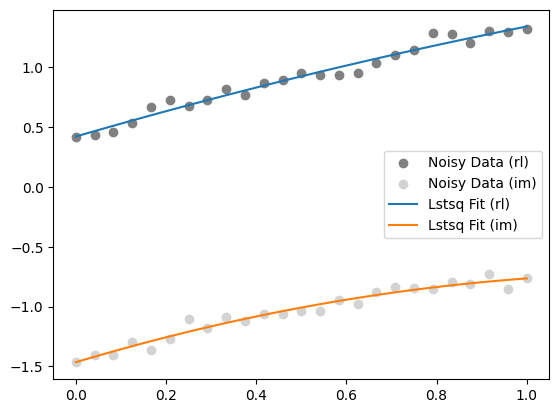

In [72]:
plt.scatter(x, data.real, label="Noisy Data (rl)", color='gray')
plt.scatter(x, data.imag, label="Noisy Data (im)", color='lightgray')

evaluated_fit = complex_fit()
plt.plot(x, evaluated_fit.real, label="Lstsq Fit (rl)", color='C0')
plt.plot(x, evaluated_fit.imag, label="Lstsq Fit (im)", color='C1')

plt.legend()